#0. OBJETIVO DEL ANÁLISIS DE SERIES TEMPORAL

El objetivo de este cuaderno es mostrar los pasos a seguir al hacer el análisis. El archivo cargado es un dataset ya limpio.

#1. IMPORTAR LIBRERÍAS NECESARIAS

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose #Para la descomposición
import matplotlib.pyplot as plt #Para visualizaciones
from statsmodels.tsa.holtwinters import ExponentialSmoothing #Para ETS

from sklearn.metrics import mean_absolute_error, mean_squared_error


#2. CARGAR EL DATASET

In [ ]:
df = pd.read_csv('limpieza_eda_pildora.csv')
#Asegurarnos de que sea un dataframe
df=pd.DataFrame(df)

#3. DATA OVERVIEW

In [ ]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [ ]:
df_copy.describe()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


In [ ]:
#Se hace una copia para no perder información en el csv original si se llega a hacer alguna modificación.
df_copy =df.copy()

#4. ANÁLISIS DE SERIES TEMPORAL

##4.1. ASEGURAR QUE DATE SEA FECHA Y EL ÍNDICE DEL DATAFRAME

Aunque se cambió el tipo de columna en la limpieza y EDA, al exportarlo no se mantienen los cambios, así que nos aseguramos ahora de que la fecha esté como tal.

Además, necesitamos que la fecha sea el índice del dataframe en este tipo de análisis.

In [ ]:
#Nos aseguramos que la columna de 'Date' sea una fecha y el índice del dataframe.
df_copy['Date'] = pd.to_datetime(df_copy['Date'])
df_copy.set_index('Date', inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73100 entries, 2022-01-01 to 2024-01-01
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Store ID            73100 non-null  object 
 1   Product ID          73100 non-null  object 
 2   Category            73100 non-null  object 
 3   Region              73100 non-null  object 
 4   Inventory Level     73100 non-null  int64  
 5   Units Sold          73100 non-null  int64  
 6   Units Ordered       73100 non-null  int64  
 7   Demand Forecast     73100 non-null  float64
 8   Price               73100 non-null  float64
 9   Discount            73100 non-null  int64  
 10  Weather Condition   73100 non-null  object 
 11  Holiday/Promotion   73100 non-null  int64  
 12  Competitor Pricing  73100 non-null  float64
 13  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(6)
memory usage: 8.4+ MB


##4.2. DESCOMPOSICIÓN


En este caso es un análisis descriptivo, ya que resume las características principales de un dataset. Además, ayuda a comprender patrones, tendencias y variaciones estacionales en los datos.

Nuestra serie temporal serán las unidades vendidas.

Ponemos la serie aditiva porque se ve que la estacionalidad es estable y el ruido no va aumentando con la serie.

- Serie = trend + seasonality + resid

El periodo que le vamos a poner será de 365 días ya que en los datos hay varios años.

Los componentes son:
- Tendencia (Trend): cómo evoluciona a largo plazo.
- Estacionalidad (Seasonality): patrones repetitivos (por ejemplo cada día, cada mes o cada año)
- Residuo (Resid): lo que queda cuando se quitan las dos anteriores.

In [ ]:
#Agrupamos las fechas para que solo haya una fila con una fecha.
df_daily = df_copy.groupby('Date')['Units Sold'].sum()

In [ ]:
df_daily.describe()

,Units Sold
count,731.000000
mean,13646.487004
std,1031.958966
min,10642.000000
25%,12981.000000
50%,13673.000000
75%,14323.500000
max,17239.000000


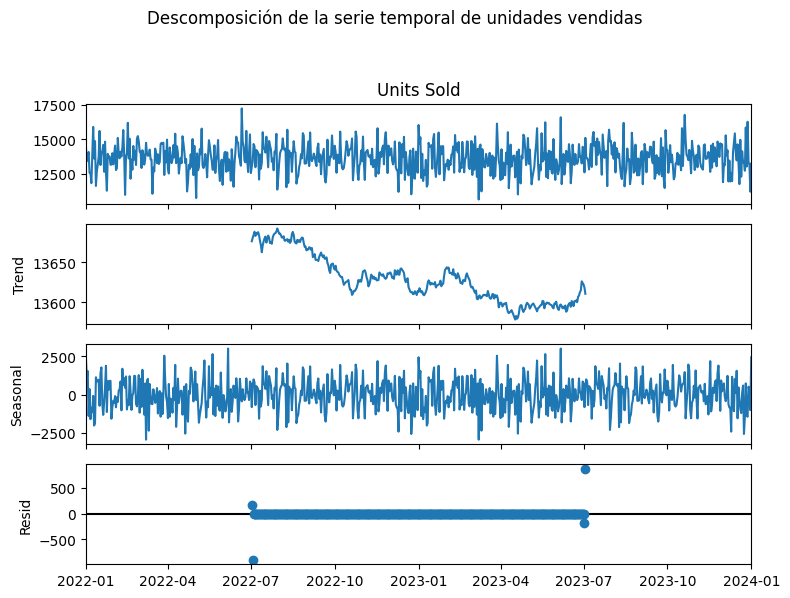

In [ ]:
#Descomposición en los componentes de la serie
decomposition = seasonal_decompose(df_daily, model='additive', period=365)

# Dibujamos la gráfica
fig = decomposition.plot()
fig.set_size_inches(8, 6)
plt.suptitle('Descomposición de la serie temporal de unidades vendidas', y=1.02) #y=1.02 evita que se solapen los subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) #Estos números ajustan los márgenes
plt.show()

#El primer gráfico es lo observado

Conclusiones de la descomposición:

- Trend (evolución a largo plazo): Las ventas son estables pero tiene una ligera tendencia a decrecer en el tiempo.
- Seasonality (patrón repetitivo cada 365 días): no hay una estacionalidad (no hay patrones claros), por lo que las ventas probablemente no dependerán de ciclos.
- Resid (lo que queda sin trend ni seasonality): al no haber patrones evidentes, se demuestra que la descomposicón captura bien la estructura de la serie.

El siguiente paso sería usar el modelo.


##4.3. MODELO Error - Trend - Seasonal (ETS)

###4.3.1. Para una frecuencia de 365 días

In [ ]:
#Modelo
model = ExponentialSmoothing(
    df_daily,
    trend='add',
    seasonal='add',
    seasonal_periods=365
)

#Entrenamiento
fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Units Sold   No. Observations:                  731
Model:             ExponentialSmoothing   SSE                      410860800.234
Optimized:                         True   AIC                          10415.966
Trend:                         Additive   BIC                          12111.305
Seasonal:                      Additive   AICC                         11184.835
Seasonal Periods:                   365   Date:                 Sun, 01 Feb 2026
Box-Cox:                          False   Time:                         12:54:46
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.0654157                alpha                 True
smoothing_trend       

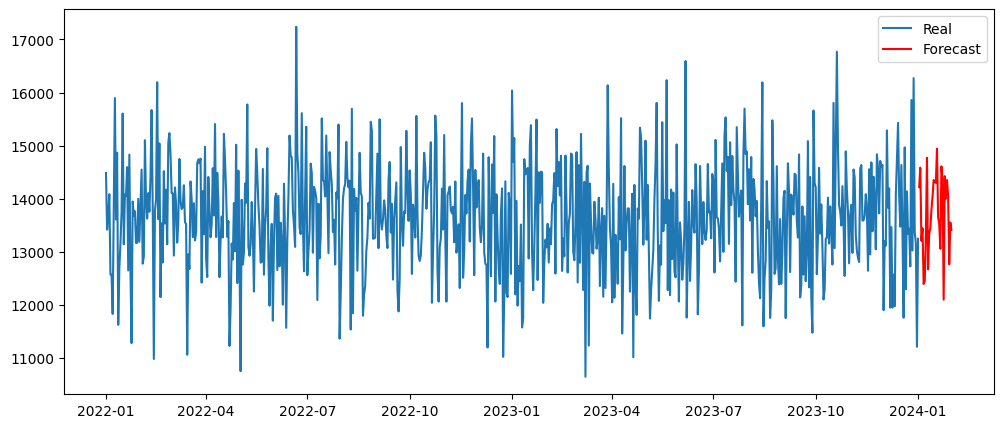

In [ ]:
#Gráfica con predicción (forecast)
forecast = fit.forecast(30)

plt.figure(figsize=(12,5))
plt.plot(df_daily, label='Real')
plt.plot(forecast, label='Forecast',color='red')
plt.legend()
plt.show()

###4.3.2. Haciendo un split para poder obtener métricas y comparar más con otros modelos.

In [ ]:
#Entrenamos con todo menos los últimos 30 días que serán la parte para testearlo.
train = df_daily.iloc[:-30]
test  = df_daily.iloc[-30:]

In [ ]:
#Modelo
model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=7
)
#Necesita tener mínimo el doble de datos, por eso usamos 7 y no 365.

#Entrenamiento
fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
#Predicción con la parte de test.
y_pred = fit.forecast(len(test))

In [ ]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Units Sold   No. Observations:                  701
Model:             ExponentialSmoothing   SSE                      780579374.292
Optimized:                         True   AIC                           9782.050
Trend:                         Additive   BIC                           9832.128
Seasonal:                      Additive   AICC                          9782.580
Seasonal Periods:                     7   Date:                 Sun, 01 Feb 2026
Box-Cox:                          False   Time:                         12:54:47
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0073998                alpha                 True
smoothing_trend          

In [ ]:
#Para hacer predicciones
forecast = fit.forecast(30)
print(forecast)

2023-12-03    13815.333100
2023-12-04    13544.038849
2023-12-05    13774.610878
2023-12-06    13847.695461
2023-12-07    13694.255874
2023-12-08    13563.362255
2023-12-09    14000.146855
2023-12-10    13818.335452
2023-12-11    13547.041201
2023-12-12    13777.613230
2023-12-13    13850.697813
2023-12-14    13697.258226
2023-12-15    13566.364607
2023-12-16    14003.149207
2023-12-17    13821.337804
2023-12-18    13550.043553
2023-12-19    13780.615582
2023-12-20    13853.700165
2023-12-21    13700.260578
2023-12-22    13569.366959
2023-12-23    14006.151559
2023-12-24    13824.340156
2023-12-25    13553.045905
2023-12-26    13783.617934
2023-12-27    13856.702517
2023-12-28    13703.262930
2023-12-29    13572.369311
2023-12-30    14009.153911
2023-12-31    13827.342508
2024-01-01    13556.048257
Freq: D, dtype: float64


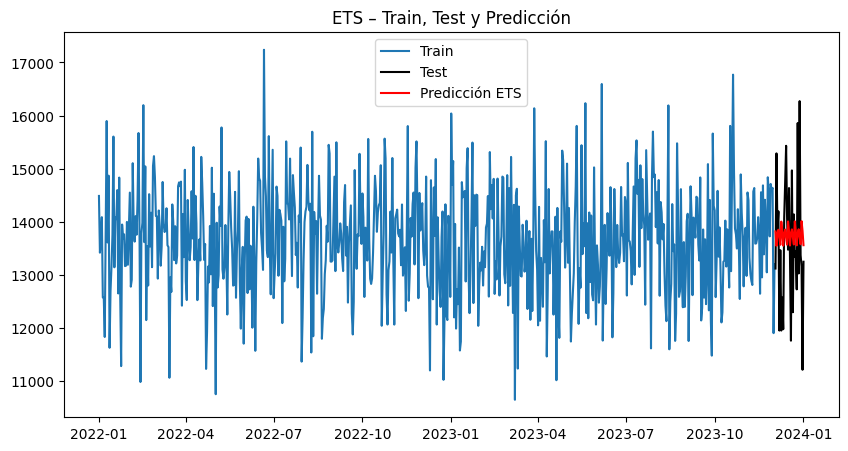

In [ ]:
#Gráfica con train, test y lo predicho.
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(y_pred.index, y_pred, label='Predicción ETS', color='red')
plt.legend()
plt.title('ETS – Train, Test y Predicción')
plt.show()

In [ ]:
print(fit.summary())
print("\nForecast próximos 60 días:")
print(forecast)

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Units Sold   No. Observations:                  701
Model:             ExponentialSmoothing   SSE                      780579374.292
Optimized:                         True   AIC                           9782.050
Trend:                         Additive   BIC                           9832.128
Seasonal:                      Additive   AICC                          9782.580
Seasonal Periods:                     7   Date:                 Sun, 01 Feb 2026
Box-Cox:                          False   Time:                         12:54:48
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0073998                alpha                 True
smoothing_trend          

Comparamos los valores predichos con los reales.

In [ ]:
mae = mean_absolute_error(test, y_pred)
rmse = np.sqrt(mean_squared_error(test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 1033.34
RMSE: 1269.09


*   **MAE (Mean Absolute Error):** Mide el promedio de las diferencias absolutas entre las predicciones y los valores reales. Un MAE de 1033.34 significa que, en promedio, las predicciones se desvían en unas 1033.34 unidades de las ventas reales.

*   **RMSE (Root Mean Squared Error):** Es similar al MAE, pero penaliza más los errores grandes al elevar al cuadrado las diferencias antes de promediarlas y luego sacar la raíz cuadrada. Un RMSE de 1269.09 indica que la magnitud de los errores es un poco mayor, especialmente si hay valores atípicos o errores significativos.

In [ ]:
mean_error_percent = forecast_df['Error %'].mean()
print(f"La media del Error % es: {mean_error_percent:.2f}%")

std_error_percent = forecast_df['Error %'].std()
print(f"La desviación estándar del Error % es: {std_error_percent:.2f}%")

La media del Error % es: 7.76%
La desviación estándar del Error % es: 5.87%


In [ ]:
#Tabla con fecha (índice), el valor real y el predicho
forecast_df = pd.DataFrame({
    "Real": test,
    "Predicción ETS": y_pred
})

#Error
forecast_df["Error"] = forecast_df["Real"] - forecast_df["Predicción ETS"]

#Error en %
forecast_df["Error %"] = (
    forecast_df["Error"].abs() / forecast_df["Real"]
) * 100

forecast_df.head()

,Real,Predicción ETS,Error,Error %
2023-12-03,13116,13815.333100,-699.333100,5.331908
2023-12-04,15286,13544.038849,1741.961151,11.395795
2023-12-05,13829,13774.610878,54.389122,0.393298
2023-12-06,14194,13847.695461,346.304539,2.439795
2023-12-07,11947,13694.255874,-1747.255874,14.625060


In [ ]:
resumen_modelo = pd.DataFrame({
    "Modelo": ["ETS"],
    "Seasonal period": [7],
    "AIC": [fit.aic],
    "BIC": [fit.bic],
    "MAE": [mae],
    "RMSE": [rmse],
    "Media error": [mean_error_percent],
    "Desviación estándar": [std_error_percent]
})

resumen_modelo

,Modelo,Seasonal period,AIC,BIC,MAE,RMSE,Media error,Desviación estándar
0,ETS,7,9782.050411,9832.127998,1033.337764,1269.087183,7.758483,5.874214
